# Wykop - Links - Analysis

## Setup

In [1]:
import glob
import json
import random
import datetime
from collections import Counter

from wordcloud import WordCloud

from scipy import stats
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick

In [2]:
# wykop.pl colors

wykop_orange = '#f58237'
wykop_blue = '#367da9'

## Utils

In [3]:
def read_link(filepath):
    with open(filepath, 'r') as f:
        content = f.read()
    return json.loads(content)

## Data

### Download Data

Data was downloaded with the script ./bin/download_hits.py

Steps
1. git clone https://github.com/dsinaction/wykop-tags # clone repo
2. cd wykop-tags # change directory
3. python3 -m virtualen venv # set up virtual evironment
4. pip install -e . # install package, required for WykopAPI used by download_hits
5. run the script, use one or more API keys

```bash
for year in `seq 2006 2021`
do
    for month in `seq 1 12`
    do
        ./bin/download_hits.py $year $month notebooks/links $WYKOP_API_KEY1$ $WYKOP_API_KEY2 $$WYKOP_API_KEY3
    done
done
```

In [4]:
!ls links

2006  2008  2010  2012	2014  2016  2018  2020
2007  2009  2011  2013	2015  2017  2019  2021


### Data Processing

In [5]:
dataset_path = 'links/'

In [6]:
link_files = list(glob.iglob(dataset_path + '**/*.json', recursive=True))
random.shuffle(link_files)

print(f'There are {len(link_files)} records in the dataset.')

There are 339033 records in the dataset.


In [7]:
df_links = pd.DataFrame([read_link(link_file) for link_file in tqdm(link_files)])

df_links['tags'] = df_links['tags'].apply(lambda x: x.split() if isinstance(x, str) else None)

df_links['date'] = pd.to_datetime(df_links['date'], format='%Y-%m-%d %H:%M:%S')
df_links['year'] = df_links['date'].dt.year
df_links['month'] = df_links['date'].dt.month

df_links = df_links[df_links.tags.notnull()]

  0%|          | 0/339033 [00:00<?, ?it/s]

In [8]:
df_links.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 339032 entries, 0 to 339032
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   id              339032 non-null  int64         
 1   title           339031 non-null  object        
 2   description     339028 non-null  object        
 3   tags            339032 non-null  object        
 4   source_url      339032 non-null  object        
 5   vote_count      339032 non-null  int64         
 6   bury_count      339032 non-null  int64         
 7   comments_count  339032 non-null  int64         
 8   related_count   339032 non-null  int64         
 9   date            339032 non-null  datetime64[ns]
 10  author          339032 non-null  object        
 11  preview         306422 non-null  object        
 12  plus18          339032 non-null  bool          
 13  status          339032 non-null  object        
 14  can_vote        339032 non-null  boo

In [9]:
df_links.head()

,id,title,description,tags,source_url,vote_count,bury_count,comments_count,related_count,date,...,preview,plus18,status,can_vote,is_hot,archived,app,info,year,month
0,1690868,Setki młodych lwowian powtórzyło przysięgę żoł...,Przy okazji dzieciom opowiedziano o „nienawist...,"[#europa, #wydarzenia, #polska, #ukraina, #upa...","http://www.kresy.pl/wydarzenia,spoleczenstwo?z...",360,17,93,1,2013-10-14 14:06:46,...,https://www.wykop.pl/cdn/c3397993/link_HRsQXMy...,False,promoted,True,False,True,NaN,NaN,2013,10
1,5916581,#otwieraMY: W Wiśle otwarto stoki narciarskie,W piątek pierwszy ośrodek w Wiśle otworzył się...,"[#polska, #koronawirus, #bekazpisu, #gospodark...",https://naszapolska.pl/2021/01/23/otwieramy-w-...,651,7,76,0,2021-01-23 08:42:07,...,https://www.wykop.pl/cdn/c3397993/link_1611387...,False,promoted,True,False,NaN,NaN,NaN,2021,1
2,3364199,Beka z fanów Appla. Testowali nowe słuchawki z...,nie ma to jak bezkrytyczni fani Appla,"[#zainteresowania, #ciekawostki]",http://www.youtube.com/watch?v=tMirx_bwmWk,896,145,131,0,2016-09-20 13:12:23,...,https://www.wykop.pl/cdn/c3397993/link_renWQ3J...,False,promoted,True,False,NaN,NaN,NaN,2016,9
3,4689165,Rosyjskie czołgi przy granicy z Ukrainą. Ukrai...,Ukraińscy eksperci zwrócili uwagę na zdjęcia s...,"[#ukraina, #hahard, #rosja, #wojna, #geopolity...",https://www.wykop.pl/link/partnerredirect/4689...,575,74,125,2,2018-12-11 10:11:30,...,https://www.wykop.pl/cdn/c3397993/link_cfQbnIL...,False,promoted,True,False,NaN,NaN,NaN,2018,12
4,3898205,MSZ Węgier: Polscy przyjaciele mogą na nas lic...,"Polska może liczyć na solidarność Węgier, a st...","[#polska, #europa, #polityka, #wegry, #4konser...",http://www.rp.pl/Unia-Europejska/170839765-MSZ...,325,17,34,2,2017-08-31 15:38:03,...,https://www.wykop.pl/cdn/c3397993/link_iftXKQY...,False,promoted,True,False,NaN,NaN,NaN,2017,8


## Analysis

#### What was the minimal number of votes required to be in the first 10/20/50/100 of the most popular links?

In [162]:
df = df_links.copy()

In [163]:
# rank links by number of votes within a single month
df['rank'] = df.groupby(by=['year', 'month'])['vote_count'] \
    .transform(lambda x: x.rank(method='first', ascending=False))

In [164]:
def get_min_votes_df(top_n):
    df_min_votes = df[df['rank'] == top_n] \
        .sort_values(['year', 'month'])[['year', 'month', 'vote_count']]
    df_min_votes['period'] = df_min_votes.apply(lambda x: datetime.datetime(x.year, x.month, 1), axis=1)
    return df_min_votes

In [165]:
df_top5_min_votes = get_min_votes_df(5)
df_top10_min_votes = get_min_votes_df(10)
df_top20_min_votes = get_min_votes_df(20)
df_top50_min_votes = get_min_votes_df(50)

In [170]:
df_top5_min_votes.groupby(['year']).agg(votes=('vote_count', 'mean'))

,votes
year,
2006,136.416667
2007,249.750000
2008,781.916667
2009,1563.000000
2010,1503.416667
2011,1854.416667
2012,2239.500000
2013,2390.000000
2014,3174.166667


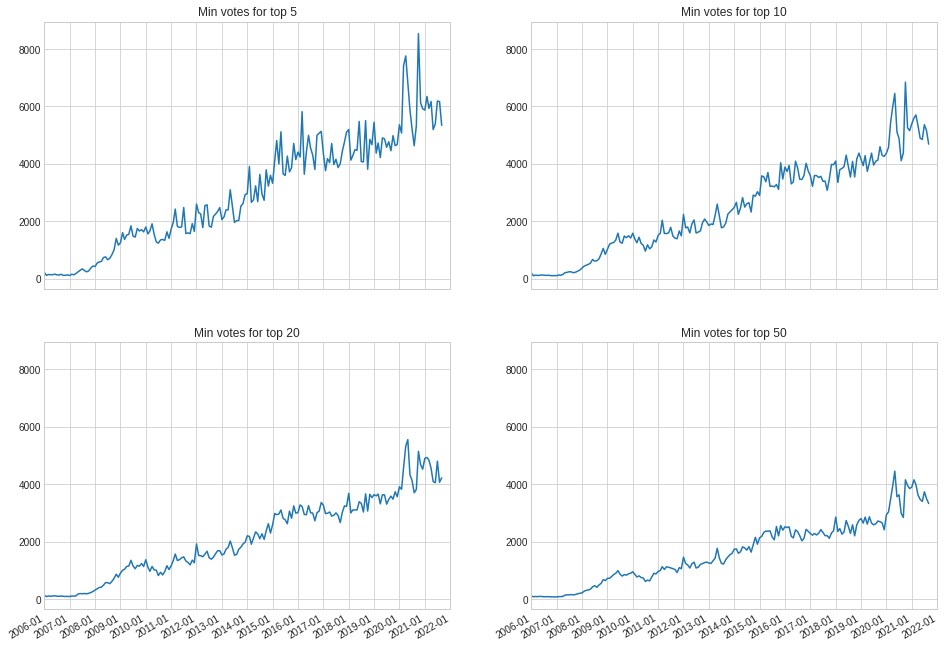

In [198]:
fig, axes = plt.subplots(ncols=2, nrows=2, sharex='all', sharey='all', figsize=(16, 12))

axes[0,0].plot('period', 'vote_count', data=df_top5_min_votes)
axes[0,1].plot('period', 'vote_count', data=df_top10_min_votes)
axes[1,0].plot('period', 'vote_count', data=df_top20_min_votes)
axes[1,1].plot('period', 'vote_count', data=df_top50_min_votes)

fmt_half_year = mdates.MonthLocator(interval=12)
axes[0,0].xaxis.set_major_locator(fmt_half_year)

fmt_month = mdates.MonthLocator() 
axes[0,0].xaxis.set_minor_locator(fmt_month)
axes[0,0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

datemin = np.datetime64(df_top5_min_votes['period'].iloc[0], 'Y')
datemax = np.datetime64(df_top5_min_votes['period'].iloc[-1], 'Y') + np.timedelta64(1, 'Y')
axes[0,0].set_xlim(datemin, datemax)

axes[0,0].grid(True)
axes[0,1].grid(True)
axes[1,0].grid(True)
axes[1,1].grid(True)

axes[0,0].title.set_text('Min votes for top 5')
axes[0,1].title.set_text('Min votes for top 10')
axes[1,0].title.set_text('Min votes for top 20')
axes[1,1].title.set_text('Min votes for top 50')

for ax in axes.flatten():
    ax.yaxis.set_tick_params(labelleft=True)
    
fig.autofmt_xdate()

plt.savefig('images/min_votes.png', dpi=100, transparent=False, bbox_inches='tight')
plt.show()

#### What were the most popular tags?

In [83]:
links_by_year = df_links.groupby(['year']).agg(total_links=('id', 'count'))

In [84]:
df_tags = df_links[['id', 'year', 'tags']].explode(['tags']) \
    .rename(columns={'tags': 'tag'}) \
    .groupby(['year', 'tag']) \
    .agg(n=('id', 'count'))

df_tags['rank'] = df_tags.groupby(by=['year'])['n'] \
    .transform(lambda x: x.rank(method='first', ascending=False))

df_tags['n_perc'] = df_tags.join(links_by_year).apply(lambda x: x.n/x.total_links, axis=1)

df_tags.reset_index(inplace=True)

In [85]:
df_popular = df_tags[(df_tags['rank'] <= 10) & (df_tags['year'].isin([2008, 2021]))].reset_index()
df_popular['item'] = df_popular.apply(lambda x: (x.tag, x.n_perc), axis=1)

labels = df_popular['tag'].unique().tolist()

df_popular = df_tags[df_tags['tag'].isin(labels)]

tags_ref = {
    record['tag']: record['n_perc']
    for record in df_popular[df_popular['year'] == 2008][['tag', 'n_perc']].to_dict('records')
}

tags_new = {
    record['tag']: record['n_perc']
    for record in df_popular[df_popular['year'] == 2021][['tag', 'n_perc']].to_dict('records')
}

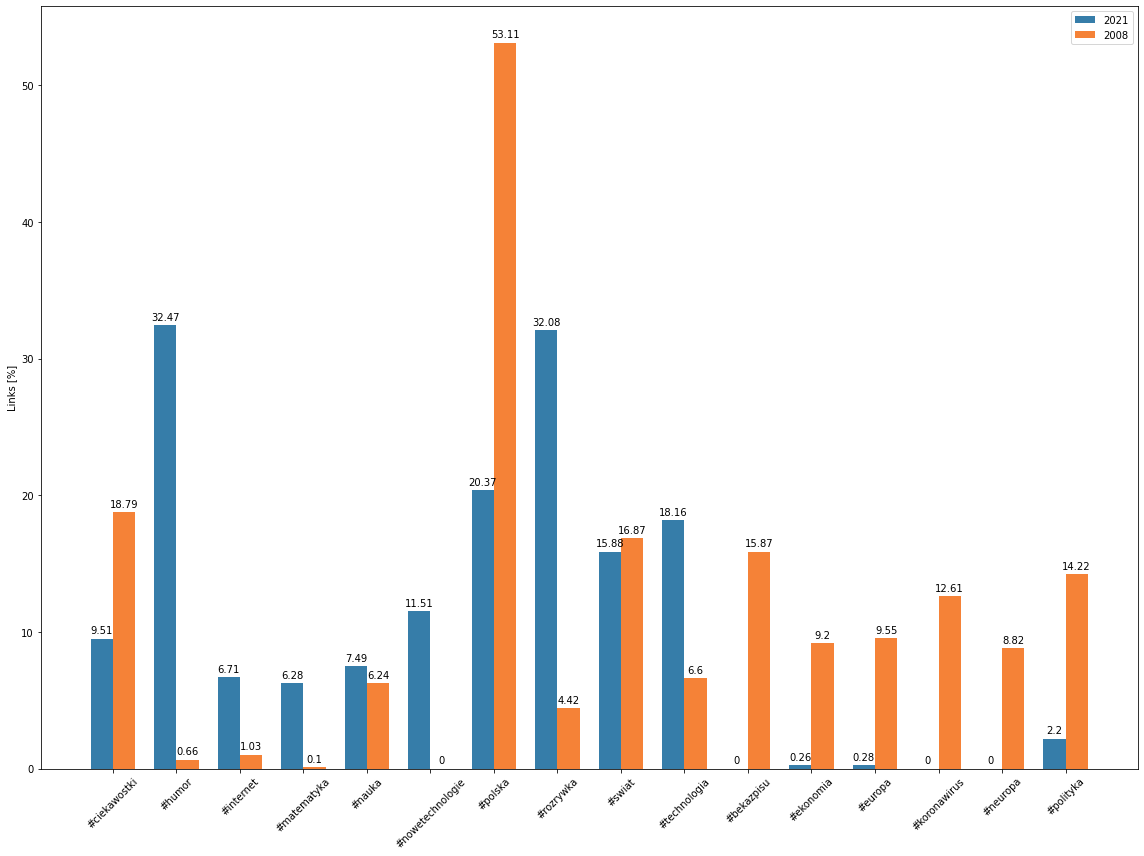

In [86]:
tags_ref = [ round(100*tags_ref.get(label, 0.0), 2) for label in labels ]
tags_new = [ round(100*tags_new.get(label, 0.0), 2) for label in labels ]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(16, 12))
rects1 = ax.bar(x - width/2, tags_ref, width, label='2021', color=wykop_blue)
rects2 = ax.bar(x + width/2, tags_new, width, label='2008', color=wykop_orange)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Links [%]')
# ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.savefig('images/popular_tags_shift.png', dpi=100, transparent=False, bbox_inches='tight')
plt.show()

In [87]:
df_popular = df_tags[df_tags['rank'] <= 5].reset_index()
df_popular['item'] = df_popular.apply(lambda x: (x.tag, x.n_perc), axis=1)

for year, tags in df_popular.groupby(['year'])['item'].apply(list).items():
    print(year, ' ', end='')
    for tag, share in sorted(tags, key=lambda x: x[1], reverse=True):
        print('{:.1f}% - {:15.10s}'.format(100*share, tag), end='')
    print()

2006  43.2% - #technolog     25.9% - #nowetechn     23.7% - #humor         22.9% - #rozrywka      17.1% - #internet      
2007  32.2% - #humor         31.7% - #rozrywka      25.3% - #technolog     19.7% - #polska        16.1% - #nowetechn     
2008  32.5% - #humor         32.1% - #rozrywka      20.4% - #polska        18.2% - #technolog     15.9% - #swiat         
2009  28.1% - #polska        27.6% - #rozrywka      27.5% - #humor         19.0% - #swiat         11.8% - #technolog     
2010  21.2% - #polska        11.8% - #rozrywka      10.7% - #swiat         9.4% - #humor         9.2% - #nauka         
2011  15.3% - #zainteres     15.2% - #polska        12.8% - #rozrywka      11.6% - #nauka         11.3% - #ciekawost     
2012  24.1% - #polska        14.8% - #zainteres     14.1% - #nauka         10.6% - #ciekawost     8.9% - #rozrywka      
2013  39.2% - #polska        24.5% - #ciekawost     17.5% - #swiat         13.3% - #zainteres     12.6% - #rozrywka      
2014  47.7% - #polska      

In [193]:
df_popular = df_tags[df_tags['rank'] <= 10].reset_index()
popular_tags = df_popular['tag'].unique().tolist()
df_popular = df_tags[df_tags['tag'].isin(popular_tags)]

df_popular.to_csv('popular_tags.csv', index=False)

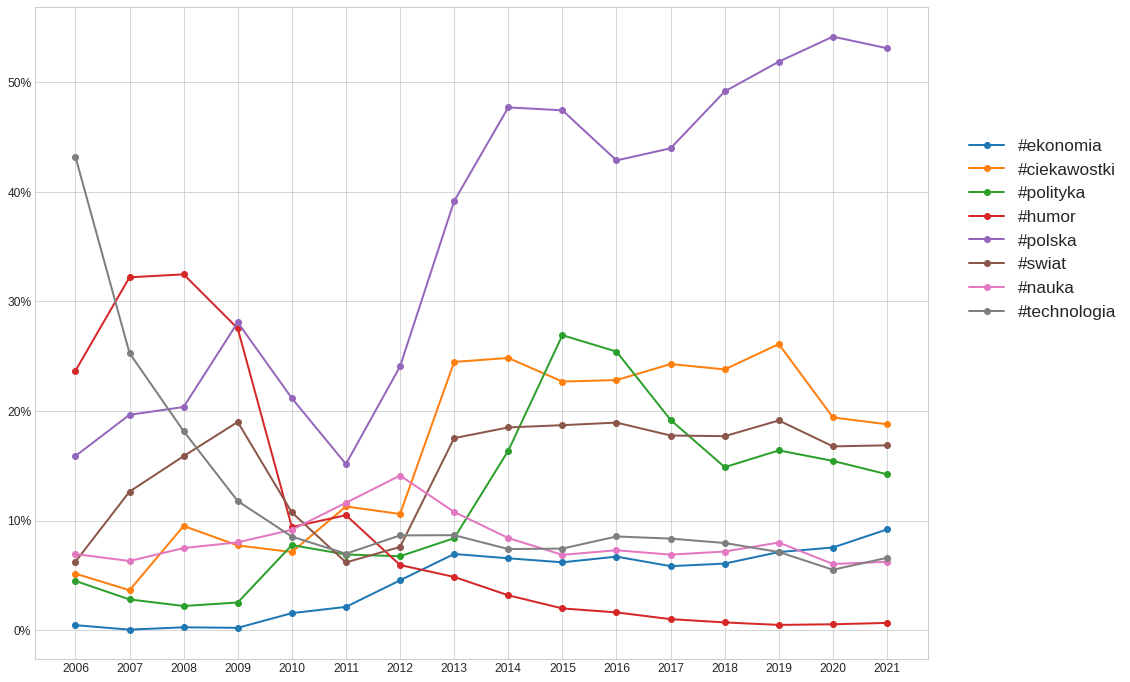

In [200]:
tags = ['#ekonomia', '#ciekawostki', '#polityka', '#humor',  '#polska', '#swiat', 
        '#nauka', '#technologia']

df = df_tags.copy()
df['n_perc'] = df['n_perc']*100
df['year'] = df['year'].apply(lambda x: str(x))

plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(16, 12))

for tag in tags:
    ax.plot('year', 'n_perc', data=df[df['tag'] == tag], linewidth=2, marker='o', label=tag)

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

fig.legend(loc='lower center', bbox_to_anchor=(1, 0.5), fontsize='xx-large')

plt.savefig('images/popular_tags_series.png', dpi=100, transparent=False, bbox_inches='tight')
plt.show()

#### Identify tags that were only popular for short period of time

In [55]:
df_tags = df_links[['id', 'year', 'month', 'tags']].explode(['tags']) \
    .rename(columns={'tags': 'tag'}) \
    .groupby(['year', 'month', 'tag']) \
    .agg(n=('id', 'count')) \
    .reset_index()

df_tags['rank'] = df_tags.groupby(by=['year', 'month'])['n'] \
    .transform(lambda x: x.rank(method='first', ascending=False))

df_tags = df_tags[(df_tags['rank'] <= 5)]

In [56]:
popular_tags = df_tags.groupby(['tag']).agg(n=('tag', 'count'))\
    .reset_index() \
    .query('n <= 2')['tag'].tolist()

In [57]:
df_tags[df_tags['tag'].isin(popular_tags)].sort_values(['year', 'month'])

,year,month,tag,n,rank
68066,2010,3,#kultura,77,4.0
143430,2012,1,#acta,418,2.0
148405,2012,2,#acta,209,4.0
168502,2012,6,#euro,188,4.0
171086,2012,6,#sport,167,5.0
208827,2013,5,#zboze,367,4.0
234292,2014,6,#aferapodsluchowa,369,4.0
255272,2015,5,#wybory,611,4.0
261924,2015,9,#imigranci,1148,3.0
261950,2015,9,#islam,689,5.0


#### What were the most popular sources?

In [10]:
from urllib.parse import urlparse

def extract_domain(url):
    domain = urlparse(url).netloc
    return domain[4:] if domain.startswith('www.') else domain

def modify_domains(domain):
    if domain in ['youtube.com', 'youtu.be', 'pl.youtube.com' ]:
        return 'youtube.com'
    return domain

In [11]:
df_links['source_domain'] = df_links.source_url.apply(lambda x: modify_domains(extract_domain(x)))

In [17]:
links_by_year = df_links.groupby(['year']).agg(total_links=('id', 'count')).reset_index()

df_domains = df_links[['id', 'year', 'source_domain']] \
    .groupby(['year', 'source_domain']) \
    .agg(n=('id', 'count')) \
    .reset_index()

df_domains['n_perc'] = df_domains.merge(links_by_year, on=['year'])\
    .apply(lambda x: x.n/x.total_links, axis=1)

popular_domains = ['wykop.pl', 'streamable.com', 'twitter.com', 'facebook.com', 'youtube.com']
popular_domains = ['wykop.pl', 'youtube.com']
df_domains = df_domains[~df_domains['source_domain'].isin(popular_domains)]

df_domains['rank'] = df_domains.groupby(by=['year'])['n'] \
    .transform(lambda x: x.rank(method='first', ascending=False))

In [18]:
df_popular = df_domains[df_domains['rank'] <= 5].reset_index()
df_popular['item'] = df_popular.apply(lambda x: (x.source_domain, x.n), axis=1)

for year, tags in df_popular.groupby(['year'])['item'].apply(list).items():
    print(year, ' ', end='')
    for domain, n in sorted(tags, key=lambda x: x[1], reverse=True):
        print('{:s} ({:d}) '.format(domain, n), end='')
    print()

2006  serwisy.gazeta.pl (67) wiadomosci.gazeta.pl (65) wiadomosci.onet.pl (31) gospodarka.gazeta.pl (26) video.google.com (25) 
2007  wiadomosci.gazeta.pl (100) wiadomosci.onet.pl (57) di.com.pl (48) wiadomosci24.pl (48) kopalniawiedzy.pl (43) 
2008  dziennik.pl (77) webhosting.pl (51) rp.pl (49) joemonster.org (45) eioba.pl (44) 
2009  pokazywarka.pl (511) rp.pl (118) wiadomosci.onet.pl (90) dziennik.pl (83) imgur.com (69) 
2010  pokazywarka.pl (456) i.imgur.com (256) rp.pl (127) wiadomosci.onet.pl (98) vimeo.com (85) 
2011  i.imgur.com (836) pokazywarka.pl (784) wiadomosci.onet.pl (186) liveleak.com (180) wiadomosci.gazeta.pl (180) 
2012  pokazywarka.pl (429) liveleak.com (319) tvn24.pl (244) wiadomosci.gazeta.pl (244) rp.pl (224) 
2013  liveleak.com (672) tvn24.pl (367) pokazywarka.pl (286) wiadomosci.gazeta.pl (258) i.imgur.com (240) 
2014  liveleak.com (625) wpolityce.pl (412) tvn24.pl (383) natemat.pl (300) niezalezna.pl (294) 
2015  wpolityce.pl (627) liveleak.com (603) niezalez

In [19]:
df_popular = df_domains[df_domains['rank'] <= 10].reset_index()
popular_sources = df_popular['source_domain'].unique().tolist()
df_popular = df_domains[df_domains['source_domain'].isin(popular_sources)]

df_popular.to_csv('popular_sources.csv', index=False)

### Which tags go together the most?

Association rule learning

#### Data Prepration

In [142]:
df_tags = df_links[df_links.year == 2021].copy()

df_tags.tags = df_tags.tags.apply(lambda tags: list(set(tags)))
df_tags = df_tags[['id', 'tags']].explode(['tags']) \
    .rename(columns={'tags': 'tag'})
df_tags['tag'] = df_tags['tag'].apply(lambda x: x.lstrip('#'))
df_tags = df_tags[df_tags.tag != '']
df_tags['n'] = 1

In [143]:
df_tags_aggr = df_tags.groupby(['tag']) \
    .agg(n=('id', 'count')) \
    .reset_index()

popular_tags = set(df_tags_aggr[df_tags_aggr['n'] > 100]['tag'].to_list())

print(f'There are {len(popular_tags)} popular tags.')

There are 177 popular tags.


In [144]:
# Keep only popular tags & remove links without any tags
df_tags = df_tags[df_tags['tag'].apply(lambda tag: tag in popular_tags)]

#### Assocation rule maining

In [145]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [146]:
basket = df_tags.groupby(['id', 'tag'])['n'].sum()\
    .unstack().reset_index().fillna(0)\
    .set_index('id')

In [147]:
frequent_itemsets = apriori(basket, min_support=0.025, use_colnames=True)

In [148]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(bekazpisu),(bekazprawakow),0.160695,0.040680,0.025852,0.160877,3.954735,0.019315,1.143242
1,(bekazprawakow),(bekazpisu),0.040680,0.160695,0.025852,0.635506,3.954735,0.019315,2.302658
2,(bekazpisu),(koronawirus),0.160695,0.127761,0.026969,0.167825,1.313587,0.006438,1.048144
3,(koronawirus),(bekazpisu),0.127761,0.160695,0.026969,0.211087,1.313587,0.006438,1.063875
4,(bekazpisu),(neuropa),0.160695,0.089314,0.051844,0.322623,3.612240,0.037492,1.344430


In [149]:
rules.sort_values(['support'], ascending=False).head(n=30)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
8,(polska),(bekazpisu),0.537941,0.160695,0.141192,0.262468,1.633333,0.054748,1.137992
9,(bekazpisu),(polska),0.160695,0.537941,0.141192,0.878637,1.633333,0.054748,3.807235
40,(polska),(polityka),0.537941,0.143984,0.107979,0.200726,1.394093,0.030524,1.070993
41,(polityka),(polska),0.143984,0.537941,0.107979,0.749939,1.394093,0.030524,1.847789
28,(polska),(koronawirus),0.537941,0.127761,0.076300,0.141838,1.110186,0.007573,1.016404
29,(koronawirus),(polska),0.127761,0.537941,0.076300,0.597215,1.110186,0.007573,1.147160
6,(bekazpisu),(polityka),0.160695,0.143984,0.064752,0.402953,2.798602,0.041615,1.433750
7,(polityka),(bekazpisu),0.143984,0.160695,0.064752,0.449721,2.798602,0.041615,1.525236
25,(ekonomia),(polska),0.093151,0.537941,0.062834,0.674532,1.253914,0.012724,1.419675
24,(polska),(ekonomia),0.537941,0.093151,0.062834,0.116804,1.253914,0.012724,1.026781


### What were the most popular words in titles?

In [36]:
from wordcloud import WordCloud

In [37]:
import re
import string

re_punc = re.compile('[%s]' % re.escape(string.punctuation))
re_print = re.compile(r'[^%s]' % re.escape(string.printable + 'ęóąśłżźń'))
re_tokens = re.compile(r'[a-zęóąśłżźńA-ZĘÓĄŚŁŻŹŃ\']+')

def tokenize(text, lower_case=True, drop_non_printable=True):
    tokens = re_tokens.findall(text)
    tokens = [ re_punc.sub('', token) for token in tokens ]
    if drop_non_printable: 
        words = [ re_print.sub('', token) for token in tokens ]
    if lower_case:
        words = [ token.lower() for token in tokens ]
    return words

In [38]:
# source: https://pl.wikipedia.org/wiki/Wikipedia:Stopwords

stopwords = 'a, aby, ach, acz, aczkolwiek, aj, albo, ale, ależ, ani, aż, bardziej, bardzo, bo, bowiem, by, byli, bynajmniej, być, był, była, było, były, będzie, będą, cali, cała, cały, ci, cię, ciebie, co, cokolwiek, coś, czasami, czasem, czemu, czy, czyli, daleko, dla, dlaczego, dlatego, do, dobrze, dokąd, dość, dużo, dwa, dwaj, dwie, dwoje, dziś, dzisiaj, gdy, gdyby, gdyż, gdzie, gdziekolwiek, gdzieś, i, ich, ile, im, inna, inne, inny, innych, iż, ja, ją, jak, jaka, jakaś, jakby, jaki, jakichś, jakie, jakiś, jakiż, jakkolwiek, jako, jakoś, je, jeden, jedna, jedno, jednak, jednakże, jego, jej, jemu, jest, jestem, jeszcze, jeśli, jeżeli, już, ją, każdy, kiedy, kilka, kimś, kto, ktokolwiek, ktoś, która, które, którego, której, który, których, którym, którzy, ku, lat, lecz, lub, ma, mają, mało, mam, mi, mimo, między, mną, mnie, mogą, moi, moim, moja, moje, może, możliwe, można, mój, mu, musi, my, na, nad, nam, nami, nas, nasi, nasz, nasza, nasze, naszego, naszych, natomiast, natychmiast, nawet, nią, nic, nich, nie, niech, niego, niej, niemu, nigdy, nim, nimi, niż, no, o, obok, od, około, on, ona, one, oni, ono, oraz, oto, owszem, pan, pana, pani, po, pod, podczas, pomimo, ponad, ponieważ, powinien, powinna, powinni, powinno, poza, prawie, przecież, przed, przede, przedtem, przez, przy, roku, również, sama, są, się, skąd, sobie, sobą, sposób, swoje, ta, tak, taka, taki, takie, także, tam, te, tego, tej, temu, ten, teraz, też, to, tobą, tobie, toteż, trzeba, tu, tutaj, twoi, twoim, twoja, twoje, twym, twój, ty, tych, tylko, tym, u, w, wam, wami, was, wasz, wasza, wasze, we, według, wiele, wielu, więc, więcej, wszyscy, wszystkich, wszystkie, wszystkim, wszystko, wtedy, wy, właśnie, z, za, zapewne, zawsze, ze, zł, znowu, znów, został, żaden, żadna, żadne, żadnych, że, żeby'
stopwords = set([ word.strip() for word in stopwords.split(',') ])

In [39]:
re_html_entity = re.compile(r'&.*?;')

def preprocess(title, stopwords):
    if not isinstance(title, str): return ''
    title = re_html_entity.sub('', title)
    tokens = tokenize(title)
    tokens = [ token for token in tokens if len(token) >= 2 and token not in stopwords ]
    return ' '.join(tokens)

In [43]:
df = df_links[['title', 'year']].copy()
df['title'] = df['title'].apply(lambda title: preprocess(title, stopwords))

titles = ' '.join(df[df['year'] == 2021].title)

wc3 = WordCloud(max_font_size=90, background_color='white', 
                width=1024, height=768) \
    .generate(titles)

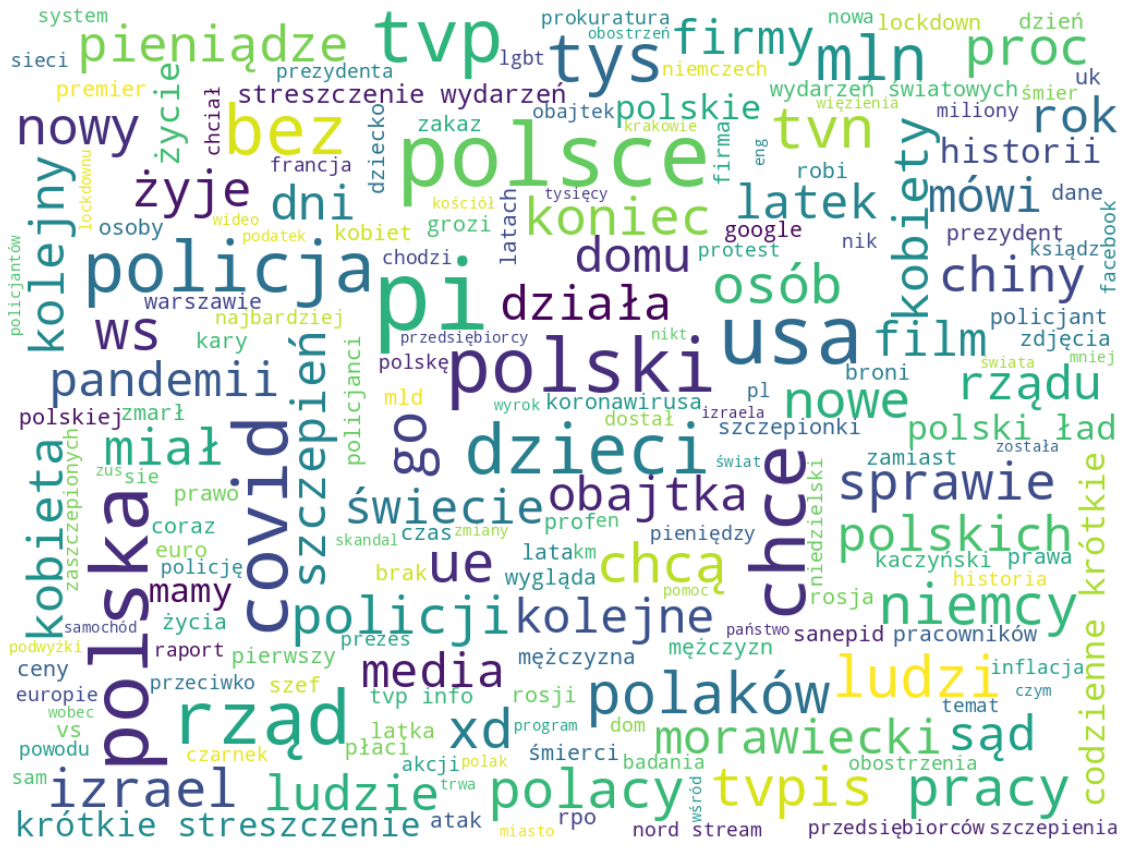

In [44]:
plt.figure(figsize=(20, 20))
plt.imshow(wc3, interpolation="bilinear")
plt.axis("off")
plt.savefig('images/wordcloud_2021.png', dpi=100, transparent=False, bbox_inches='tight')
plt.show()

### Which users' links are the most upvoted?

In [76]:
df = df_links.copy()
df['author'] = df.author.apply(lambda author: author['login'])
df['rank'] = df.groupby(by=['year', 'month'])['vote_count'] \
    .transform(lambda x: x.rank(method='first', ascending=False))

In [77]:
df = df[df['vote_count'] > 100]

In [78]:
df_authors = df[['id', 'year', 'author']] \
    .groupby(['year', 'author']) \
    .agg(n=('id', 'count')) \
    .reset_index()

df_authors['rank'] = df_authors.groupby(by=['year'])['n'] \
    .transform(lambda x: x.rank(method='first', ascending=False))

In [79]:
links_by_year = df.groupby(['year']).agg(links_year=('year', 'count')).reset_index()

df_authors = df_authors.merge(links_by_year, on=['year'])
df_authors['n_p'] = df_authors['n']/df_authors['links_year']

In [95]:
df_popular = df_authors[df_authors['rank'] <= 3].reset_index()
df_popular['item'] = df_popular.apply(lambda x: (x.author, x.n, x.n_p), axis=1)

for year, tags in df_popular.groupby(['year'])['item'].apply(list).items():
    print('| <sub>', year, '</sub> | ', end='')
    for domain, n, n_p in sorted(tags, key=lambda x: x[1], reverse=True):
        print('<sub>{:.12s} - {:d} ({:.1f}%)</sub> | '.format(domain, n, 100*n_p), end='')
    print()

| <sub> 2006 </sub> | <sub>KKKas - 7 (2.8%)</sub> | <sub>gordi7 - 7 (2.8%)</sub> | <sub>adas - 5 (2.0%)</sub> | 
| <sub> 2007 </sub> | <sub>NamalowanyPr - 38 (2.3%)</sub> | <sub>rybeczka - 23 (1.4%)</sub> | <sub>NowyPremier - 13 (0.8%)</sub> | 
| <sub> 2008 </sub> | <sub>rybeczka - 68 (1.3%)</sub> | <sub>_tomek_ - 57 (1.1%)</sub> | <sub>tomaszs - 39 (0.8%)</sub> | 
| <sub> 2009 </sub> | <sub>_tomek_ - 144 (1.5%)</sub> | <sub>kaszpirofsky - 118 (1.3%)</sub> | <sub>NiEb0 - 108 (1.1%)</sub> | 
| <sub> 2010 </sub> | <sub>reddigg - 106 (1.1%)</sub> | <sub>kaszpirofsky - 87 (0.9%)</sub> | <sub>kubatre1 - 84 (0.8%)</sub> | 
| <sub> 2011 </sub> | <sub>reddigg - 453 (2.5%)</sub> | <sub>kubatre1 - 236 (1.3%)</sub> | <sub>abram66 - 148 (0.8%)</sub> | 
| <sub> 2012 </sub> | <sub>kajakkajak - 217 (1.1%)</sub> | <sub>GraveDigger - 185 (1.0%)</sub> | <sub>siwymaka - 174 (0.9%)</sub> | 
| <sub> 2013 </sub> | <sub>p........... - 220 (0.9%)</sub> | <sub>c....o - 206 (0.9%)</sub> | <sub>GraveDigger - 205

| Rok      | Pierwsze Miejsce | Drugie Miejsce     | Trzecie Miejsce |
| :----:       |     ---:  |          ---: |          ---: |
|  2006 | <sub>KKKas - 7 (2.8%)</sub> | <sub>gordi7 - 7 (2.8%)</sub> | <sub>adas - 5 (2.0%)</sub> | 
|  2007 | <sub>NamalowanyPr - 38 (2.3%)</sub> | <sub>rybeczka - 23 (1.4%)</sub> | <sub>NowyPremier - 13 (0.8%)</sub> | 
|  2008 | <sub>rybeczka - 68 (1.3%)</sub> | <sub>_tomek_ - 57 (1.1%)</sub> | <sub>tomaszs - 39 (0.8%)</sub> | 
|  2009 | <sub>_tomek_ - 144 (1.5%)</sub> | <sub>kaszpirofsky - 118 (1.3%)</sub> | <sub>NiEb0 - 108 (1.1%)</sub> | 
|  2010 | <sub>reddigg - 106 (1.1%)</sub> | <sub>kaszpirofsky - 87 (0.9%)</sub> | <sub>kubatre1 - 84 (0.8%)</sub> | 
|  2011 | <sub>reddigg - 453 (2.5%)</sub> | <sub>kubatre1 - 236 (1.3%)</sub> | <sub>abram66 - 148 (0.8%)</sub> | 
|  2012 | <sub>kajakkajak - 217 (1.1%)</sub> | <sub>GraveDigger - 185 (1.0%)</sub> | <sub>siwymaka - 174 (0.9%)</sub> | 
|  2013 | <sub>p........... - 220 (0.9%)</sub> | <sub>c....o - 206 (0.9%)</sub> | <sub>GraveDigger - 205 (0.9%)</sub> | 
|  2014 | <sub>darosoldier - 1125 (4.6%)</sub> | <sub>sportingkiel - 739 (3.0%)</sub> | <sub>reflex1 - 361 (1.5%)</sub> | 
|  2015 | <sub>darosoldier - 1044 (3.3%)</sub> | <sub>n..2 - 898 (2.8%)</sub> | <sub>sportingkiel - 723 (2.3%)</sub> | 
|  2016 | <sub>WuDwaKa - 814 (2.9%)</sub> | <sub>i.....n - 641 (2.3%)</sub> | <sub>darosoldier - 479 (1.7%)</sub> | 
|  2017 | <sub>Mesk - 1091 (3.6%)</sub> | <sub>HaHard - 806 (2.6%)</sub> | <sub>a..........a - 777 (2.5%)</sub> | 
|  2018 | <sub>a..........a - 706 (2.3%)</sub> | <sub>Cziken1986 - 699 (2.3%)</sub> | <sub>darosoldier - 528 (1.7%)</sub> | 
|  2019 | <sub>Szewczenko - 686 (2.3%)</sub> | <sub>HaHard - 670 (2.3%)</sub> | <sub>regiony - 401 (1.4%)</sub> | 
|  2020 | <sub>Szewczenko - 1990 (4.7%)</sub> | <sub>HaHard - 641 (1.5%)</sub> | <sub>tomasztomasz - 590 (1.4%)</sub> | 
|  2021 | <sub>Szewczenko - 1812 (6.2%)</sub> | <sub>Oline - 548 (1.9%)</sub> | <sub>gromota - 415 (1.4%)</sub> | 

#### Szewczenko Tags

In [89]:
df = df_links.copy()
df['author'] = df.author.apply(lambda author: author['login'])

df = df[(df['author'].isin(['Szewczenko', 'Oline', 'gromota'])) & (df['year'] == 2021)]

In [90]:
df_tags = df[['id', 'author', 'tags']].explode(['tags']) \
    .rename(columns={'tags': 'tag'}) \
    .groupby(['author', 'tag']) \
    .agg(n=('id', 'count')) \
    .reset_index()

df_tags['rank'] = df_tags.groupby(by=['author'])['n'] \
    .transform(lambda x: x.rank(method='first', ascending=False))

df_authors = df.groupby(['author']).agg(total_links=('author', 'count')).reset_index()

df_tags = df_tags.merge(df_authors, on=['author'])
df_tags['n_perc'] = df_tags['n']/df_tags['total_links']

In [91]:
df_popular = df_tags[df_tags['rank'] <= 10].reset_index()
labels = df_popular['tag'].unique().tolist()
df_popular = df_tags[df_tags['tag'].isin(labels)]

tags = {
    author: {
        record['tag']: record['n_perc']
        for record in df_popular[df_popular['author'] == author].to_dict('records')
    }
    for author in set(df_popular['author']) 
}

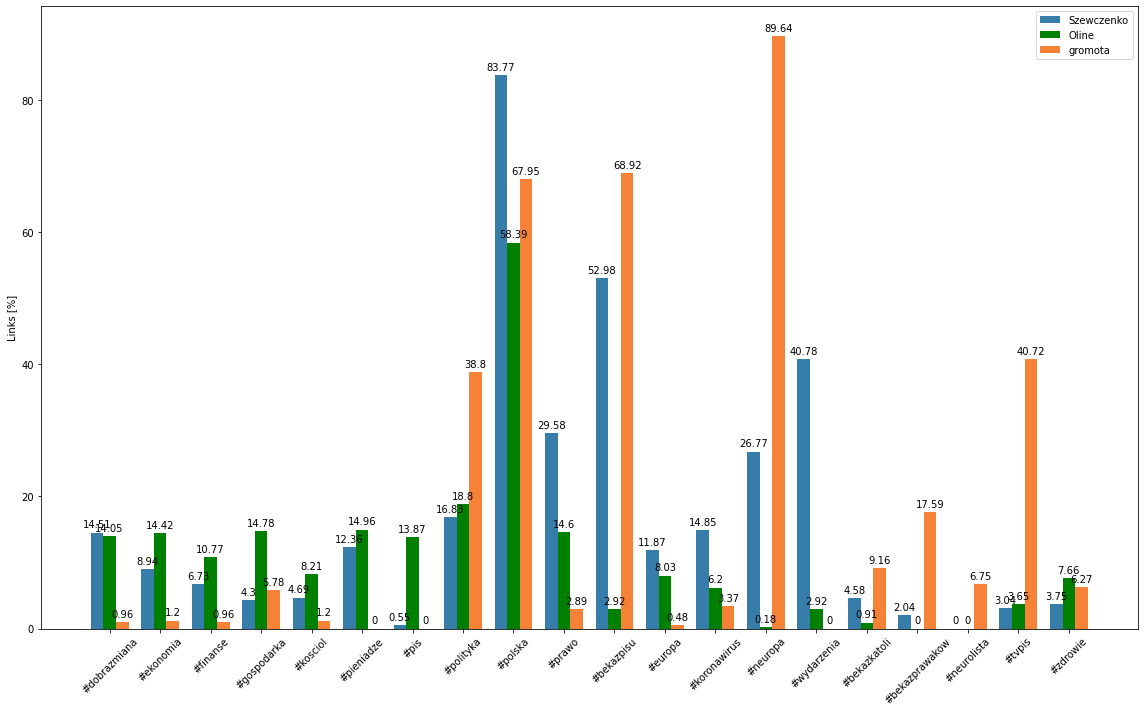

In [92]:
data_plot = {
    author: [ round(100*values.get(label, 0.0), 2) for label in labels ]
    for author, values in tags.items()
}

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(16, 10))
# rects1 = ax.bar(x - width/2, data_plot['Szewczenko'], width, label='Szewczenko', color=wykop_blue)
# rects2 = ax.bar(x + width/2, data_plot['gromota'], width, label='Oline', color=wykop_orange)

rects1 = ax.bar(x - width, data_plot['Szewczenko'], width, label='Szewczenko', color=wykop_blue)
rects2 = ax.bar(x, data_plot['Oline'], width, label='Oline', color='green')
rects3 = ax.bar(x + width, data_plot['gromota'], width, label='gromota', color=wykop_orange)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Links [%]')
# ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)

fig.tight_layout()

plt.savefig('images/popular_author_tags.jpeg', dpi=100, transparent=False, bbox_inches='tight')
plt.show()